In [1]:
import vk_api
import networkx as nx
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# input your vk login and password

login = '+79778941146'
password = 's4ed6we2e4'

vk_session = vk_api.VkApi(login=login, password=password)
vk_session.auth()
vk = vk_session.get_api()

In [3]:
# GET SOBCHAK's FRIENDS

sobchak_id = 453382669
friends = vk.friends.get(user_id=sobchak_id)['items']

In [4]:
# GET FRIENDS OF FRIENDS
# TAKES 4 MINUTES FOR SOBCHAK (245 friends)

graph_data = dict()
for friend_id in friends:
    try:
        graph_data[friend_id] = vk.friends.get(user_id=friend_id)['items']
    except Exception as e:
        graph_data[friend_id] = list()
        print(e)  # print error to control the process ("Errors, errors everywhere!")
        time.sleep(1)

    time.sleep(1)  # pauses are needed due to vk api limitations, minimum is 0.35 seconds. Do not remove!

[30] This profile is private
[30] This profile is private
[18] User was deleted or banned
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[18] User was deleted or banned
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[30] This profile is private
[18] User was deleted or banned
[30] This profile is private
[18] User was deleted or banned
[18] User was deleted or banned
[18] User was deleted or banned


In [6]:
# CREATE GRAPH AND EGO-GRAPH

graph = nx.Graph(directed=False)
for sobchak_friend in graph_data:  # add sobchak friends
    graph.add_edge(sobchak_id, sobchak_friend)
    
    for nested_friend in graph_data[sobchak_friend]:  # add friends of friends
        graph.add_edge(sobchak_friend, nested_friend)

sobchak_ego_graph = nx.ego_graph(graph, sobchak_id, radius=1, undirected=True)

In [7]:
# GET LIKES OF LAST POST

post_likes = list()
post_id = 60853  # can be defined by post's url in browser
items_in_response = 1000  # max=1000 for vk api
offsets = [0, 1000, 2000, 3000]  # offsets are needed to get more than 1000 likes due to api limitations
for offset in offsets:
    post_likes.extend(vk.likes.getList(type='post',
                                       owner_id=sobchak_id,
                                       item_id=post_id,
                                       count=items_in_response,
                                       offset=offset)['items'])
    time.sleep(1)

post_likes = list(set(post_likes))
print(len(post_likes))

3517


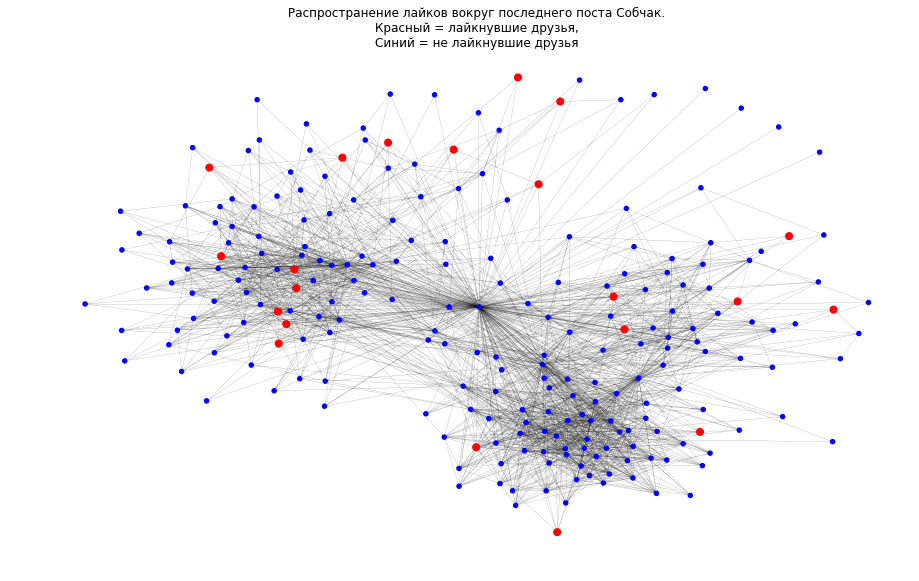

In [8]:
# DRAW GRAPH

colors = list()
sizes = list()
for vk_id in sobchak_ego_graph.nodes():
    if vk_id in post_likes:
        colors.append('red')
        sizes.append(50)
    else:
        colors.append('blue')
        sizes.append(20)

plt.figure(figsize=(12, 7))
nx.draw(sobchak_ego_graph, width=0.1, node_color=colors, node_size=sizes)
plt.title(u'Распространение лайков вокруг последнего поста Собчак.\nКрасный = лайкнувшие друзья,\nСиний = не лайкнувшие друзья');

In [9]:
# ADD FRIENDS OF FRIENDS LIKES TO EGO-GRAPH

sobchak_ego_graph_extended = sobchak_ego_graph.copy()
liked_not_in_friends = list()
for sobchak_friend in graph_data:
    for friend_nested in graph_data[sobchak_friend]:
        if friend_nested in post_likes and friend_nested not in friends:
            sobchak_ego_graph_extended.add_edge(sobchak_friend, friend_nested)

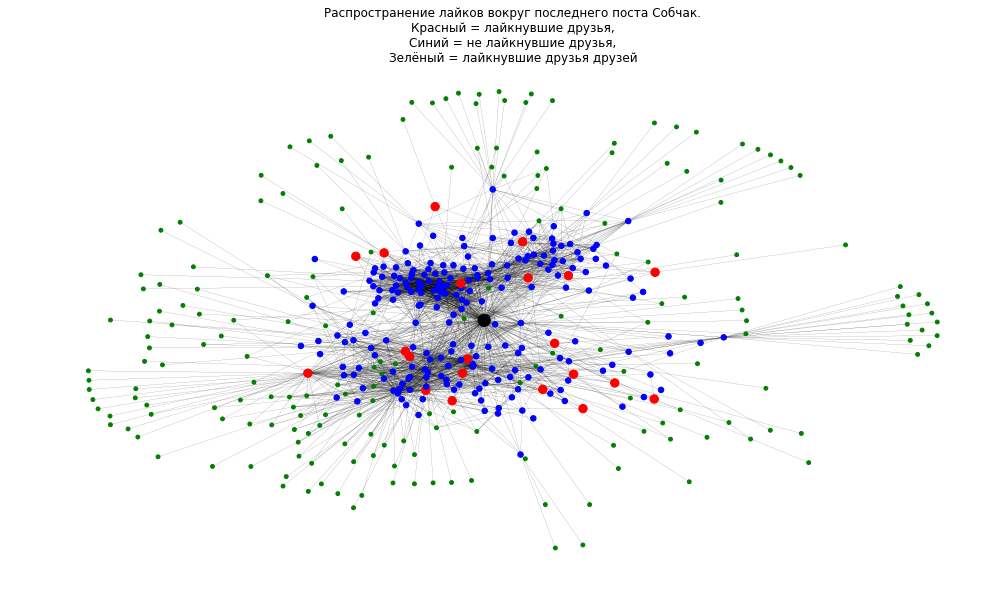

In [10]:
# DRAW GRAPH

colors_extended = list()
sizes_extended = list()
labels = dict()
for vk_id in sobchak_ego_graph_extended.nodes():
    if vk_id in friends and vk_id in post_likes:  # friend + liked
        colors_extended.append('r')
        sizes_extended.append(70)
        
    elif vk_id in friends and vk_id not in post_likes:
        colors_extended.append('b')
        sizes_extended.append(30)
        
    elif vk_id not in friends and vk_id in post_likes:
        colors_extended.append('g')
        sizes_extended.append(15)
    
    else:
        colors_extended.append('k')
        sizes_extended.append(150)
    
plt.figure(figsize=(13, 7))
nx.draw(sobchak_ego_graph_extended, node_size=sizes_extended, width=0.1, node_color=colors_extended)
plt.title(u'Распространение лайков вокруг последнего поста Собчак.\nКрасный = лайкнувшие друзья,\nСиний = не лайкнувшие друзья,\nЗелёный = лайкнувшие друзья друзей');